In [42]:
from db import connect
engine = connect()

In [43]:
import pandas as pd 

triple_df = pd.read_sql_query(
    sql="SELECT f.sbject, f.predicate, f.object FROM (SELECT sbject, predicate, object FROM wiki_research_l_triple INNER JOIN wiki_research_L_entity ON entity = sbject OR entity = object GROUP BY sbject, predicate, object) as f WHERE f.predicate <> 'seeAlso' ORDER BY f.sbject, f.predicate, f.object", 
    con=engine)
triple_df.head()

,sbject,predicate,object
0,-LSB- QUANT_S_1 -RSB- Trace Ethnography,has been influential in,Cyber-ethnography
1,AFD,is,QUANT_O_1 day process
2,AFD,is,QUANT_O_1 other thing
3,AFD,is QUANT_O_1 most important for,purposes
4,AFD,is QUANT_R_1 day process for,articles


In [45]:
triple_df['predicate'].drop_duplicates().values

array(['has been influential in', 'is', 'is QUANT_O_1 most important for',
       'is QUANT_R_1 day process for', 'is QUANT_R_1 of',
       'is QUANT_R_1 of deletion processes QUANT_O_1 most important for',
       'Regretfully do have', 'figure out', 'suggest', 'be',
       'be building on community research summit QUANT_O_1 > in',
       'be building on workshops QUANT_O_1 > in', 'is developing',
       'is developing fundraising', 'is developing fundraising Toward',
       'is developing ideas for next round of collaborations',
       'is developing ideas for next round of collaborations Toward',
       "give overview on how Wikipedia 's health content is used by different audiences In",
       'are looking for',
       'are looking for developers So unfortunately in',
       'are looking for researchers So unfortunately in', 'love',
       'love test visualizations For', 'love to interview',
       'love to interview you For', 'schedule', 'expect that to find',
       'invite', 'inv

In [65]:
predicatesubject = triple_df.loc[:, ['predicate', 'sbject']].drop_duplicates().values
predicateobject = triple_df.loc[:, ['predicate', 'object']].drop_duplicates().values

In [47]:
def setGenerater(property_entity):
  sets = {}

  for i in property_entity:
    key = i[0]
    if key not in sets:
        sets[key] = []
        sets[key].append(i[1])
    else:
        sets[key].append(i[1])
  
  return sets 

In [48]:
def jaccard(x, y):
    xset = set(x)
    yset = set(y)
    intersection = len(xset & yset)
    union = len(xset | yset)
    
    try:
        return float(intersection/union)
    except ZeroDivisionError:
        return 0.0

In [49]:
def jaccardMatrixGenerater(sets):
  sets_values = np.array(list(sets.values()))

  jaccardMatrix = np.zeros((len(sets_values), len(sets_values)))
  for i in range(len(sets_values)):
    for j in range(len(sets_values)):
      jaccardMatrix[i][j] = jaccard(sets_values[i],sets_values[j])

  return jaccardMatrix

In [50]:
def jaccardAverageMatrix(propertysubject, propertyobject):
  ps_sets = setGenerater(propertysubject)
  po_sets = setGenerater(propertyobject)
  if ps_sets.keys() == po_sets.keys():
    ps_jaccard_matrix = jaccardMatrixGenerater(ps_sets)
    po_jaccard_matrix = jaccardMatrixGenerater(po_sets)
    avg_matrix = (ps_jaccard_matrix + po_jaccard_matrix)/2
    return avg_matrix
  else:
    raise Exception('PredicateOrderIsNotTheSame!')

# Main Processing

In [68]:
import numpy as np
import collections
from scipy import spatial, cluster
from matplotlib import pyplot as plt

average_jaccard_matrix = 1 - jaccardAverageMatrix(predicatesubject, predicateobject)

jdist = spatial.distance.squareform(average_jaccard_matrix)
J = cluster.hierarchy.linkage(jdist, method="average")

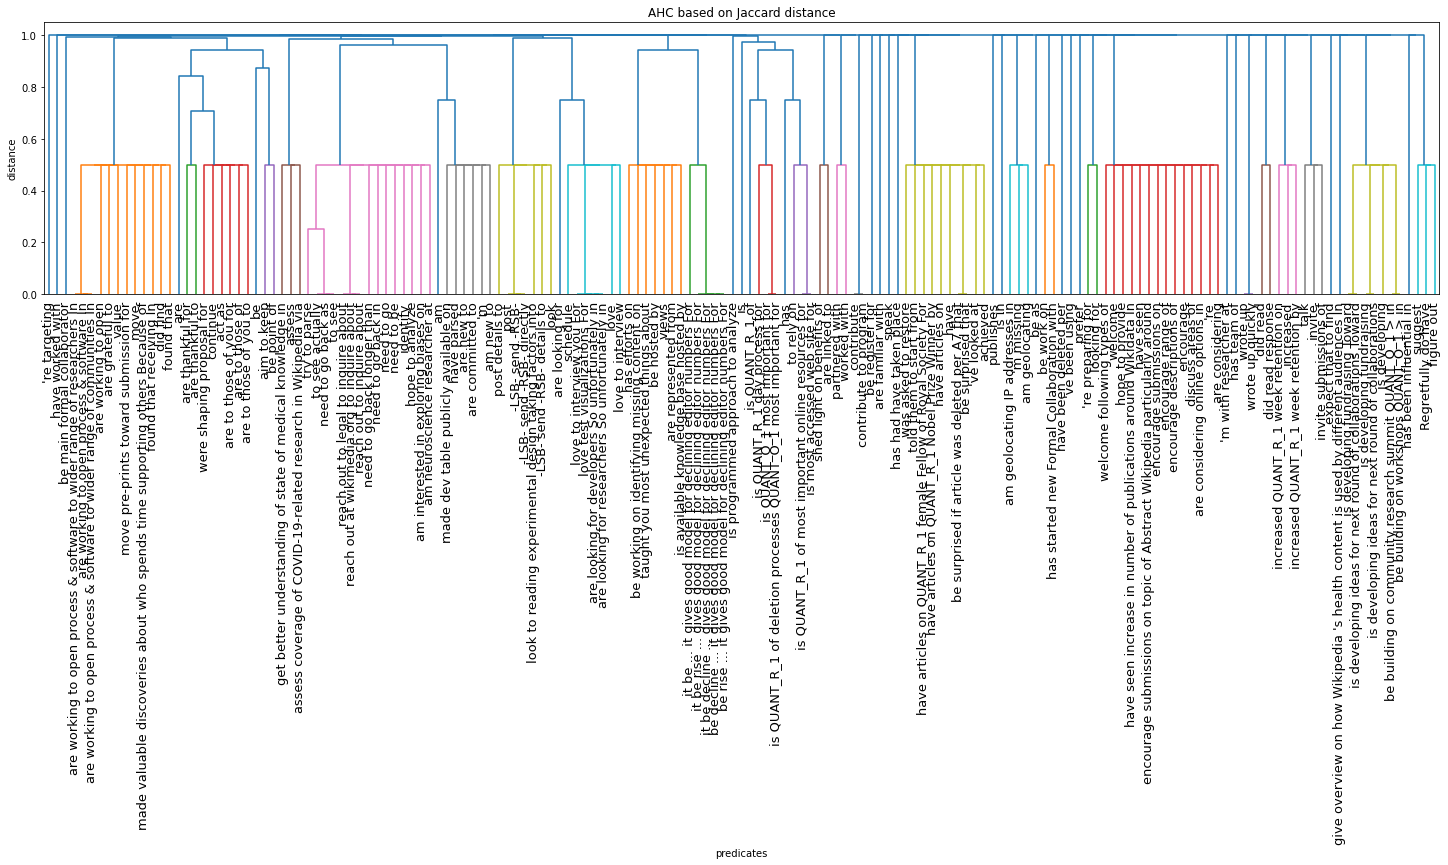

In [69]:
fig = plt.figure(figsize=(25, 5))
plt.title("AHC based on Jaccard distance")
plt.xlabel("predicates")
plt.ylabel("distance")
dn = cluster.hierarchy.dendrogram(J, labels=list(setGenerater(predicatesubject).keys()), leaf_font_size=13)
plt.show()

# SubjectのみのJaccard距離でクラスタリング 

In [70]:
jaccard_matrix_subject = 1 - jaccardMatrixGenerater(setGenerater(predicatesubject))

jdist = spatial.distance.squareform(jaccard_matrix_subject)
JS = cluster.hierarchy.linkage(jdist, method="average")

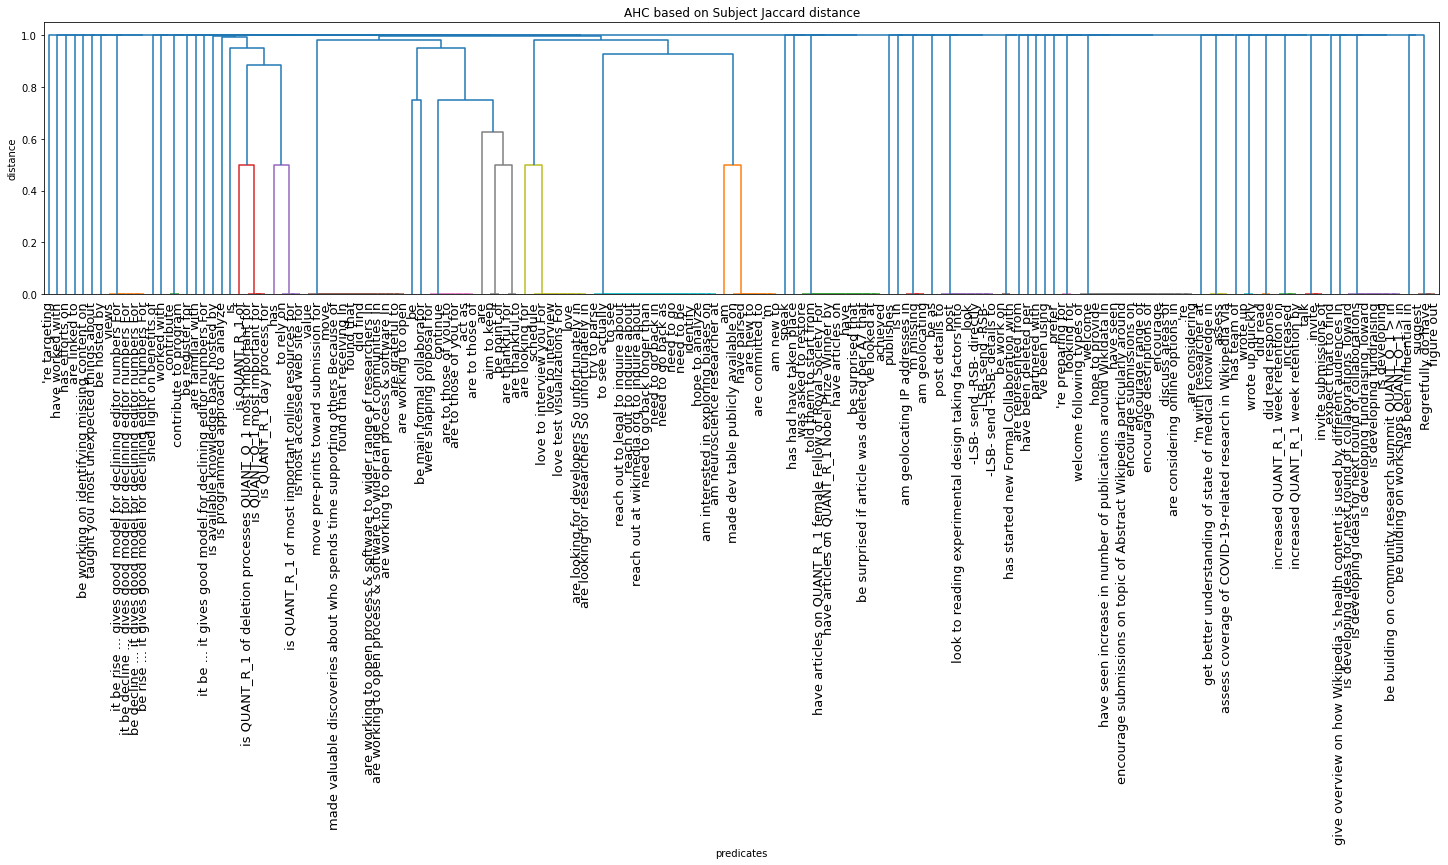

In [71]:
fig = plt.figure(figsize=(25, 5))
plt.title("AHC based on Subject Jaccard distance")
plt.xlabel("predicates")
plt.ylabel("distance")
dn = cluster.hierarchy.dendrogram(JS, labels=list(setGenerater(predicatesubject).keys()), leaf_font_size=13)
plt.show()

# ObjectのみのJaccard距離でクラスタリング

In [72]:
jaccard_matrix_object = 1 - jaccardMatrixGenerater(setGenerater(predicateobject))

jdist = spatial.distance.squareform(jaccard_matrix_object)
JO = cluster.hierarchy.linkage(jdist, method="average")

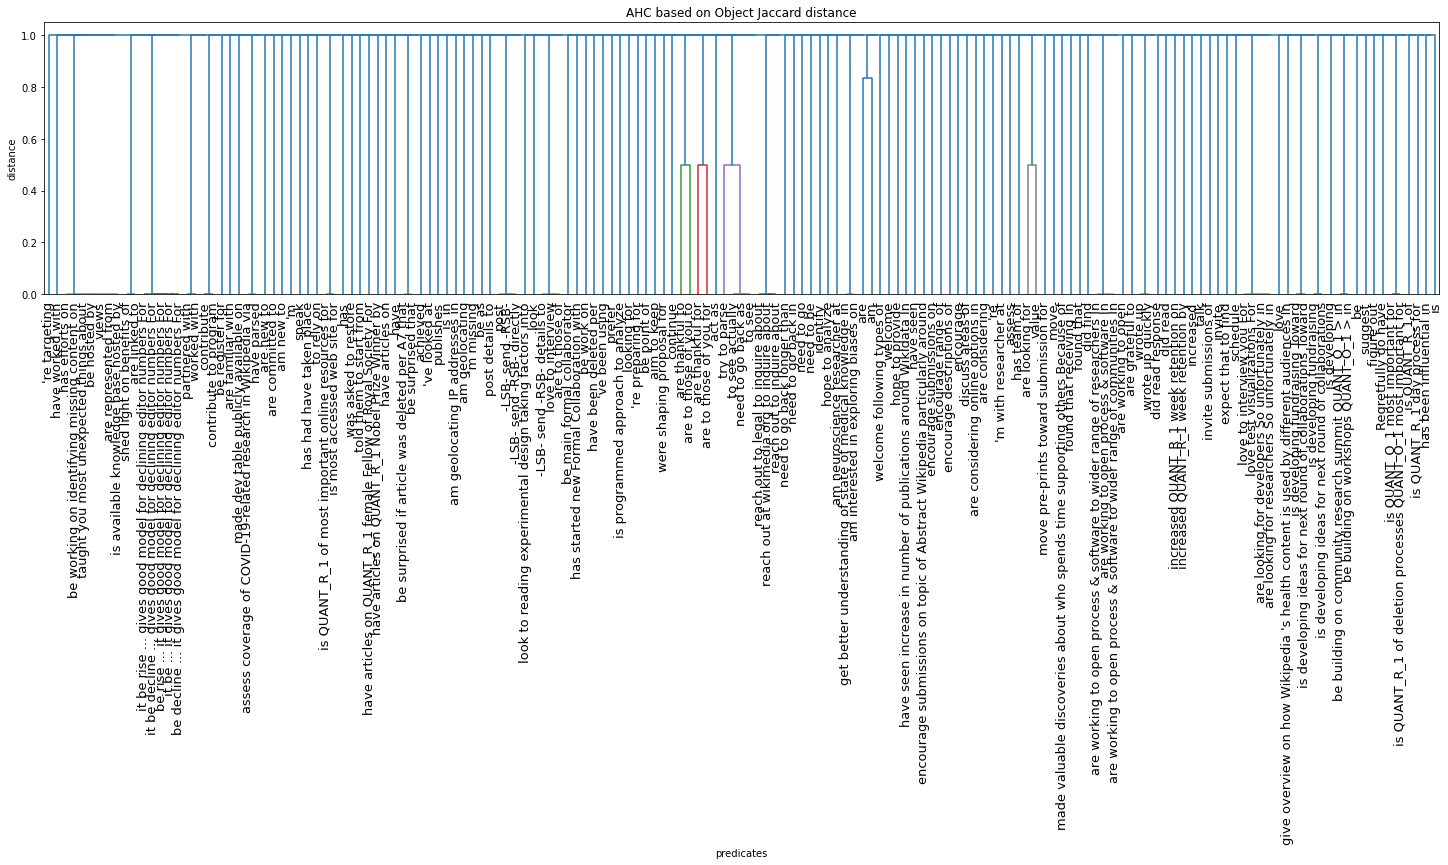

In [75]:
fig = plt.figure(figsize=(25, 5))
plt.title("AHC based on Object Jaccard distance")
plt.xlabel("predicates")
plt.ylabel("distance")
dn = cluster.hierarchy.dendrogram(JO, labels=list(setGenerater(predicateobject).keys()), leaf_font_size=13)
plt.show()